# Q1:Finding Similar Costumers using Local Sensitivity Hashing

## Q1.1 Processing of the Banking Dataset

### Required Libraries

In [165]:
import pandas as pd
import datetime
from datetime import datetime
from tqdm import tqdm as tq
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
import collections
import itertools
import re
from datetime import date
from datetime import datetime
import heapq
from heapq import *
import seaborn as sns

In [72]:
dataset=pd.read_csv('bank_transactions.csv') ###Reading the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


### Drop NaN Rowsdataset
> Since the number of rows with mising Values is very small, we decide to drop the NaN rows.

In [73]:
dataset.dropna(inplace=True)

### Customer DOB

In [74]:
dataset['CustomerDOB']=pd.to_datetime(dataset.CustomerDOB,dayfirst=True)##Converting DOB to datetime object

In [75]:
## While converting to DOB dates,some DOB are incorrectly transformed. Hence we correct those dates which have birth of year
## greater than 2000 (reasoning based on the fact the customers cannot be minors)
dataset.loc[dataset.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = dataset.loc[dataset.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [76]:

### Replacing people with DOB as 1800 to mode DOB(Replacing incorrect DOB)
mode_year=dataset[dataset.CustomerDOB.dt.year!=1800].CustomerDOB.mode()

dataset.loc[dataset.CustomerDOB.dt.year==1800,'CustomerDOB']=list(mode_year.values)[0]

## Transaction Date

In [85]:
dataset.TransactionDate=pd.to_datetime(dataset.TransactionDate,dayfirst=True) ##Converting Transaction dates to datetime object

### Create New ID for Customers:
>To deal with the cases for those account which has same customer ID but different people belong to those accounts, hence we propose to use new Customer ID made of old Customer Id and their Age.

> To deal with the cases for those accounts with different customer ID with same DOB,Gender,Account Balance(quite common).

> This is done with the view that through the Implementation of LSH we don't for a query to get results such they results have exact matching values for the query.If we want to find duplicates,we can just use Pandas methods to find duplicate's.

In [78]:
# dataset["ID"]=dataset.CustomerID + dataset.AGE.apply(lambda row:str(int(row)))+dataset.CustGender
## New Customer ID is based on Customers DOB,Gender and Account Balance(We find all the unique triplets of these combinations.)
ID = {}
j = 0
### Iterating over the dataset
for i, row in dataset.iterrows():
    ### Storing all the unique combinations of the triplets.
    if (row['CustomerDOB'], row['CustGender'], row['CustAccountBalance']) not in ID:
        ID[row['CustomerDOB'], row['CustGender'], row['CustAccountBalance']] = j
        j += 1
### Assigning the ID's to the customers
dataset['ID'] = dataset.apply(lambda x: ID[x['CustomerDOB'], x['CustGender'], x['CustAccountBalance']], axis=1)
dataset['ID'] = dataset['ID'].astype(int)


### Important Feature Extraction 

## Age of Customer
> We use DOB to find the age of the customers.The age is calculate with reference to 31st December,2016.(Feature Engineering)

In [77]:

dataset["AGE"]=((datetime(2016,12,31)-dataset.CustomerDOB)/np.timedelta64(1, "Y")).round(0)


In [87]:
def time_interval_transaction(series):
    """"
    input:series:Pandas series object
    objective: It calculates the average day in the year when usually the customer does his transactions.For each transaction of
    the customer time-difference(in days) between his transaction date and 1st January,2016 is calculated.Further we compute the
    average of all the transactions.

    return:Float
    
    """""
    
    days=[]
    for i in series:
       
        delta=i-datetime(2016,1,1,0,0,0)
        days.append(delta.days)
    return sum(days)/len(days)

### Finalising the features to compute similarity:

> We decide to use Customers Age,Account Balance,Transaction Amount and Transaction Dates to find customers with similar behaviour.

In [138]:

### Reducing the dataset on their New Customer-ID and aggregating the infomration for the customers
df_reduced=dataset.groupby('ID').agg({'AGE':['first'],'CustAccountBalance':['mean'],\
                                       'TransactionAmount (INR)':['mean'],'TransactionDate':[time_interval_transaction]})

df_reduced.columns=df_reduced.columns.droplevel(1)

df_reduced.rename(columns={'TransactionDate':'Trans_interval'},inplace=True)


In [139]:
df_reduced

,AGE,CustAccountBalance,TransactionAmount (INR),Trans_interval
ID,,,,
0,23.0,17819.05,80.111111,237.000000
1,60.0,2270.69,9503.445000,227.000000
2,20.0,17874.44,940.348182,237.181818
3,43.0,866503.21,2537.346923,244.615385
4,29.0,6714.43,1606.135000,214.000000
...,...,...,...,...
170785,26.0,218207.57,726.800000,261.000000
170786,35.0,182889.37,600.000000,261.000000
170787,24.0,15037.89,220.000000,261.000000


## Q1.2 Fingerprint Hashing

> Since the features that we are targeting have very large number of unique values(Especially transaction amount,Customer Account Balance). 

> So the idea to consider the all the unique values for all the features will give us constraint regarding memmory space.Further to elaborate, a person spending 50INR and 100 INR would be similar for the bank. 

>Hence we decide to bin the features and their respective bins would be their set of unique shingles. 

## Binning Features

In [91]:
def label_bin(row,bins):
    """"
    input:row:Pandas series object
          bins:The different bins for the feature
    objective:It calculates the bins position for a custoemr based on it's repsective features values
    returns:The bin index
    
    """""
    
    x=np.where(bins<=row)[0][-1]+1
    
    if x<len(bins):
        return x
    else:
        return x-1



In [18]:
# def label_categorical(row):
#     if (row=='M') or (row=='T') :  ### There is one row in dataset as Gender =T we assume it's male
#         return 1
#     else:
#         return 2

In [140]:
features=[] ### Contains the name of all the features bins  generated
bins=[] ### Contains the bins values used for each feature

## Dividing age into 10 bins
counts,division=pd.np.histogram(df_reduced.AGE,bins=10)
bins.append(division)
## Getting the bins for the customer based on it's Age
df_reduced['Age_bin']=df_reduced.AGE.apply(lambda row:label_bin(row,division))
features.append(['bin_A'+str(i+1) for i in range(len(division)-1)])
print('Binning Age Finished')

Binning Age Finished


<AxesSubplot:xlabel='Count', ylabel='AGE'>

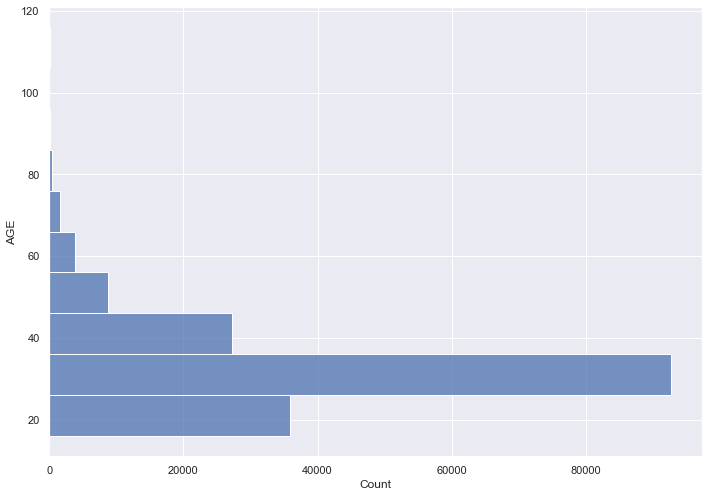

In [98]:
sns.histplot(bins=bins[0],y=df_reduced.AGE) ### Histogram representing  number of values in each bin

In [141]:
## Dividing Customer Account Balance into 45 bins

## The goal is to have a high number of bins so that the probability that multiple customer falls into a bin is low

bins_c=[list(np.linspace(0,1000,5))+list(np.linspace(3000,10000,4))+list(np.linspace(10000,100000,10))+list(np.linspace(100000,1000000,10))+\
      list(np.linspace(1000000,10000000,10))+list(np.linspace(10000000,max(df_reduced.CustAccountBalance),10))]

bins_c=list(set(bins_c[0]))
bins_c.sort()
bins.append(bins_c)
## Getting the bins for the customer based on it's account balance
counts,division=pd.np.histogram(df_reduced.CustAccountBalance,bins=bins_c)
features.append(['bin_b'+str(i+1) for i in range(len(bins_c)-1)])
df_reduced['Balance_bin']=df_reduced.CustAccountBalance.apply(lambda row:label_bin(row,division))

print('Binning Customer Balance Finished')


Binning Customer Balance Finished


<AxesSubplot:>

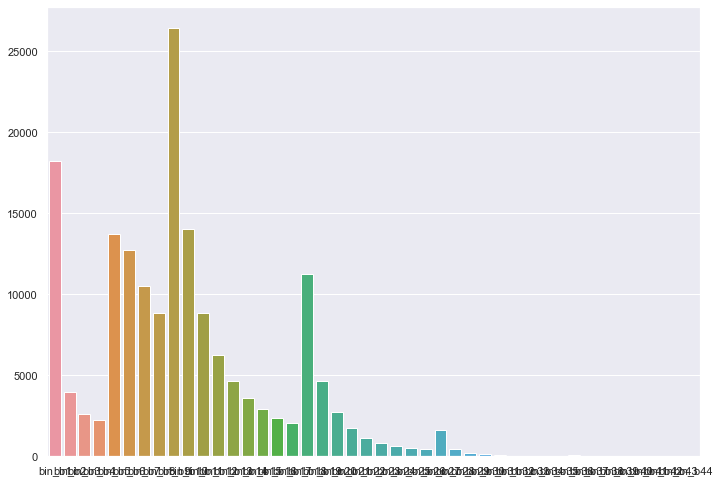

In [113]:
sns.barplot(x=features[1],y=counts)### Barplot representing  number of values in each bin

In [115]:
max(counts)/len(df_reduced) ## In worst case the max probability that two customer would share the same bin

0.1547982902980268

In [142]:
#Dividing Customer Transaction Amount to 25 bins

bins_c=[list(np.linspace(0,1000,5))+list(np.linspace(1000,10000,5))+list(np.linspace(10000,100000,10))+list(np.linspace(100000,800000,8))]

bins_c=list(set(bins_c[0]))
bins_c.sort()
bins.append(bins_c)
counts,division=pd.np.histogram(df_reduced['TransactionAmount (INR)'],bins=bins_c)
df_reduced['Transaction_bin']=df_reduced['TransactionAmount (INR)'].apply(lambda row:label_bin(row,division))
features.append(['bin_T'+str(i+1) for i in range(len(bins_c)-1)])

print('Binning Transaction Amount Finished')


Binning Transaction Amount Finished


<AxesSubplot:>

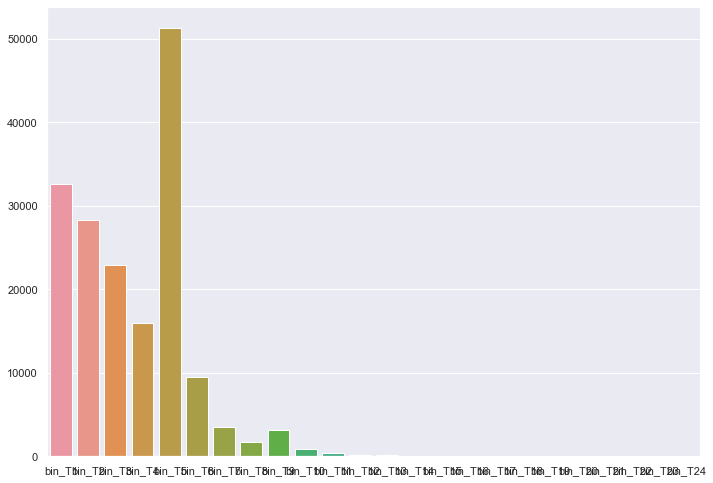

In [124]:
sns.barplot(x=features[2],y=counts) ### Barplot representing  number of values in each bin

In [143]:

# Dividing Interval between transactions into 24bins
counts,division=pd.np.histogram(df_reduced.Trans_interval,bins=24)
df_reduced['Trans_interval_bin']=df_reduced.Trans_interval.apply(lambda row:label_bin(row,division))
bins.append(division)
features.append(['bin_TI'+str(i+1) for i in range(len(division)-1)])
print('Binning Average day of the year for transaction Finished')



Binning Average day of the year for transaction Finished


<AxesSubplot:>

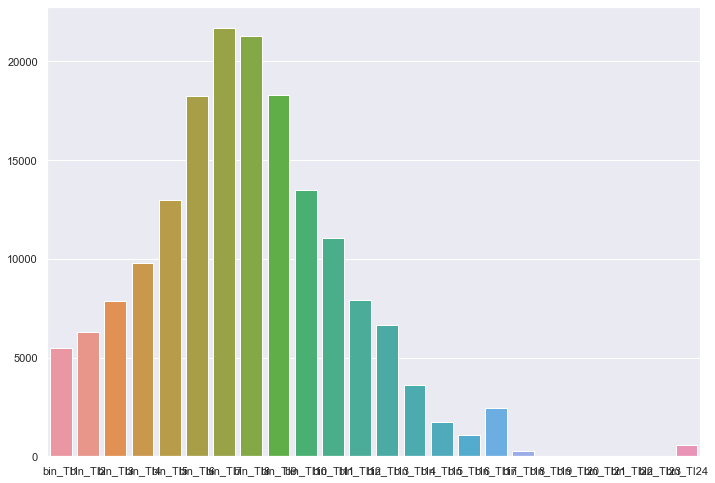

In [127]:
sns.barplot(x=features[3],y=counts) ### Barplot representing  number of values in each bin

In [144]:
df_reduced=df_reduced.reset_index()
df_reduced.drop(['ID'],axis=1,inplace=True)
df_reduced

,AGE,CustAccountBalance,TransactionAmount (INR),Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin
0,23.0,17819.05,80.111111,237.000000,1,9,1,8
1,60.0,2270.69,9503.445000,227.000000,5,5,8,5
2,20.0,17874.44,940.348182,237.181818,1,9,4,8
3,43.0,866503.21,2537.346923,244.615385,3,25,5,10
4,29.0,6714.43,1606.135000,214.000000,2,7,5,1
...,...,...,...,...,...,...,...,...
170785,26.0,218207.57,726.800000,261.000000,2,19,3,15
170786,35.0,182889.37,600.000000,261.000000,2,18,3,15
170787,24.0,15037.89,220.000000,261.000000,1,9,1,15
170788,29.0,1002.96,1146.650000,261.000000,2,5,5,15


## Going for Min Hash 

> Now we have the representation for all the shingles possible for the Customers. We get 102 possible shingles for a cusomter.We understand the number of shingles are quite low,theortically we should have very high possible shingle.

> Our decision is based on the fact that increasing more bins for the features limits the possibility of finding similar customer. For example a customer spending 10000INR is same for the bank(in behaviour-wise) as someone who spends 10500 INR.

>Next we go for creating the one-hot representation for the dataset.

> Further, we implement Min hash from the one-hot dataset.

## Creating One-Hot Matrix from the dataset

In [154]:
def one_hot(df_reduced,features):
    """"
    input:df_reduced:Pandas Dataframe
          feaures:A list,individual element is also a list which contains all the bins for respective feature.
    objective:It computes one-hot array based on binned values of the features for the customers
    returns:Numpy array: One-hot matrix
    
    """""
    
    num_features=0
    
    ## Getting total number of features
    for i in features:
        num_features+=len(i)
    
    ## allocating the space for the one-hot matrix with size: (Number of Customers, Number of features)
    final_matrix=np.zeros((len(df_reduced),num_features))
    
    ## Based on the bin value for the features the index for the 1's is calulcated 
    for _,i in tq(enumerate(df_reduced.iterrows())):
        
        final_matrix[i[0],int(i[1]['Age_bin'])-1]=1
        final_matrix[i[0],int(i[1]['Balance_bin'])-1+len(features[0])]=1
        final_matrix[i[0],int(i[1]['Transaction_bin'])-1+len(features[0])+len(features[1])]=1
        final_matrix[i[0],int(i[1]['Trans_interval_bin'])-1+len(features[0])+len(features[1])+len(features[2])]=1

        
    return final_matrix
        
        
        

In [155]:
cust_matrix=one_hot(df_reduced,features)
cust_matrix.shape

170790it [00:06, 27453.94it/s]


(170790, 102)

## Signature matrix

> The main idea behind signature matrix is that reodering the features should not effect the similarity between similar entities(here customers)

> It helps in reducing the size of the represetations of the entities(dimensionality reduction). 

> This combined with permutations help us to narrow down the search for possible similar candidates for a query and this reduces the computation in a very effective way.

In [156]:
def signature_matrix(perm:int,customer_matrix):
    """"
    input:perm:Integer,Number of permuations
          Customer_matrix:Numpy array,One-hot representation of the dataset
    objective:It computes the Signatures matrix for the customer based on the one-hot matrix of the customers.For each permutations
              the order of the features for all the customer are shuffled and then we retreive the position of first occurence of
              1.
    returns:Numpy array: Signature-Matrix
    
    """""
    
    
    ##Seeting seed for replicability in permutations
    np.random.seed(123)
    
    sig_matrix=np.zeros((customer_matrix.shape[0],perm))
    for i in tq(range(perm)):
        ## Get index of the features
        idx=np.arange(customer_matrix.shape[1])
        ## Shuffle the index
        np.random.shuffle(idx)
        ## Shuffle the customer_matrix
        customer_matrix=customer_matrix[:,idx]
        ## get positions of 1s
        one_pos=np.argwhere(customer_matrix==1)
        ##create counter to get first position of 1 for each document
        counter=0
        for j,k in enumerate(one_pos):
            ## identify the position of first one for jth document
            if k[0]==counter:
                sig_matrix[counter,i]=k[1]+1
                counter +=1
    return sig_matrix
                

In [157]:
## Going for 80 permuations and creating the signature matrix
sig_matrix=signature_matrix(80,cust_matrix)


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:30<00:00,  2.66it/s]


In [27]:
sig_matrix.shape

(170790, 80)

## Q1.3 Locality Sensitive Hashing

> Now we have obtained are signature matrix based on our dataset. Then we go for splitting the signature matrix into different bands.Number of bands should be choosen carefully,using higher bands leads to high number of False Positive and low number of bands leads to High False Negative.

>We experiment for two possible choices of Bands=40,20

> Once we divide our signature matrix into bands we hash the bands into different buckets. The main idea is that Customer's who have same value in a bands are potential similar candidate's. Hence if the customer have same values in the same band they would go in the same bucket. 

>We use different hash functions for different bands. Note:We don't use hash funcions explicitly but instead use a similar way to mimic the behviour of hash function.

### Now we go for hashing the bands to put them into buckets.Let's go for number of bands as 40 bands and 2 rows per each band

In [184]:
def Candidate_Pairs(sig_matrix,b):
    """"
    input:sig_matrix:Numpy array: The signature matrix
          b:Integer,Number of Bands
    objective:It computes the different buckets for individuals bands. So for each band based on the columns values(feature) for 
              each customer they go into buckets.The customer will share the bucket which have same columns values for that band.
              SO in this way club together those customer with similar behaviour.
    returns:Dict: Buckets
    
    """""
    
    
    n_cust,sig_dim=sig_matrix.shape
    try:
        assert(sig_dim%b==0)
    except:
        print('The Length of signature matric should be divisible ')
    ##Intialisig a deafult dict
    buckets=collections.defaultdict(set)
    
    ## Splitting the signature matrix
    bands=np.array_split(sig_matrix,b,axis=1)
    
    ##Iterating over bands
    for i,band in tq(enumerate(bands)):
        ### Iterating over customers to find their bucket 
        for  j in range(n_cust):
            
            ### Bucket key is made of tuple of values in particulAr column and index of band(which is a string object of the 
            ### band index. In this way we avoid collision of same set of values in different bands analogous to using different
            ### hash function for different bands)
            idx=tuple(list(band[j,:])+[str(i)])
            
            ### adding the document based on it's key(refer above) and value(customer index)
            buckets[idx].add(j)
    return buckets
            

In [159]:
buckets=Candidate_Pairs(sig_matrix,40)

40it [00:12,  3.16it/s]


## Querying most similar Customers based on the query data
> Now we have finished putting the customers in Dataset in buckets which form the potential similar customers.

> Then we go for finding the similar customer's for our query. We follow the similar process that we did previously for the main dataset.

>>#### We preprocess the query features into repsective bins.
>>#### We create the one-hot matrix for the query.
>>#### Then we find the signature matrix.
>>#### Based on the signature matrix we find the buckets that query hash into.
>>#### Then we use these buckets to find similar customer's and compute similarity for each query. So instead of computing the similarity between all the customers and the query,using this approach we compute similarity between very less pair's of combinations.

In [163]:
query=pd.read_csv('query_users.csv')

## Processing Features
query['CustomerDOB']=pd.to_datetime(query.CustomerDOB)
query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
query.loc[query.CustomerDOB.dt.year==1800,'CustomerDOB']=list(mode_year.values)[0]
query.TransactionDate=pd.to_datetime(query.TransactionDate,dayfirst=True)
query["AGE"]=((datetime(2016,12,31)-query.CustomerDOB)/np.timedelta64(1, "Y")).round(0)
query['Trans_interval']=query.TransactionDate.apply(lambda row:(row-datetime(2016,1,1,0,0,0)).days)

## Putting the features to their bin
query['Age_bin']=query.AGE.apply(lambda row:label_bin(row,np.array(bins[0])))
query['Balance_bin']=query.CustAccountBalance.apply(lambda row:label_bin(row,np.array(bins[1])))
query['Transaction_bin']=query['TransactionAmount (INR)'].apply(lambda row:label_bin(row,np.array(bins[2])))
query['Trans_interval_bin']=query.Trans_interval.apply(lambda row:label_bin(row,np.array(bins[3])))

query.drop(['CustomerDOB','CustGender','CustLocation','TransactionDate','TransactionTime'],axis=1,inplace=True)
query

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin
0,94695.61,65.00,38.0,245,3,17,1,10
1,7584.09,6025.00,25.0,245,1,7,7,10
2,7180.60,541.50,25.0,222,1,7,3,3
3,56847.75,1000.00,30.0,241,2,13,5,9
4,84950.13,80.00,22.0,268,1,16,1,17
5,23143.95,303.00,35.0,254,2,10,2,13
6,15397.80,20.00,40.0,240,3,9,1,9
7,426.30,50.00,25.0,214,1,2,1,1
8,4609.34,300.00,27.0,238,2,6,2,8
9,6695988.46,299.00,46.0,239,4,32,2,8


### One-hot representations of the query dataset

In [54]:
query_matrix=one_hot(query,features)
query_matrix.shape

(50, 102)

### Computing the Signature matrix of the query 

In [32]:
query_sig_matrix=signature_matrix(80,query_matrix)

100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 7302.38it/s]


### Metrics for similarity:

> We will be using Jaccard Similairty to compute similarity between potential Candidate pair(those customers who share the buckets with the query ).



In [164]:


def Jaccard_score(a,b):
    
    a=np.argwhere(a!=0)
    b=np.argwhere(b!=0)
    
    return sum(a==b)/(sum(a==b)+2*sum(a!=b))

In [62]:


def Query_LSH(query_sig_matrix,buckets,cust_matrix,thresh,bands):
    """"
    input:query_sig_matrix:Numpy array: The signature matrix based on our query
          buckets:Dict:The buckets obtained from hashing the dataset
          cust_sig_matrix:Numpy array: The signature matrix based on our dataset
          thresh:float:Threshold
          bands:Integer,Number of Bands
    objective:It computes the top-3 similar customers for each query whose similarity exceeds the threshold
    returns:result:Dict:For each query(key) we have the documents id's(value) of top-3 similar customer
            fp:Dict:For each query(key) we have the list of document id's(value) whose similarity was less than the threshold
    """""
    
    ##Storing Results:
    result={}
    ##False positives
    fp={}
    #threshold
    th=thresh
    for idx in tq(range(query_sig_matrix.shape[0])):

        ## Hashing the query bands to it's bucket
        query_buckets=Candidate_Pairs(query_sig_matrix[idx,:].reshape(1,-1),bands)

        ## Scoring Metric
        score=[]

        ## Converting List of score to heap data-structure
        heapq.heapify(score)

        ## Keeping tranks of documents that have been considered for similairity calculations to avoid multiple calculation for same 
        ## customer
        customer_list=[]

        ##Max_length
        max_length=3

        ##False_positives:
        FP=[]

        for count,i in enumerate(query_buckets):


            ## Checking if the bucket is present in buckets retrieved from the customers
            if i in list(buckets.keys()):

                ## Iterating over the customers found in matched bucket
                for j in buckets[i]:

                    if j not in customer_list:
                        #Computing Jaccard Similarity for each candidate pairs using their query and dataset one-hot matrix
                        similarity=Jaccard_score(query_matrix[idx,:],cust_matrix[j,:])
                        if similarity>=th:

                            if max_length>0:
                                #individual elment in heap is (jaccard score,document_id)
                                heappush(score,(similarity,j))
                                customer_list.append(j)
                                max_length-=1

                            else:
                                #replace the minimum of heap if the score is higher
                                if similarity>score[0][0]:
                                    heapreplace(score,(similarity,j))
                                    customer_list.append(j)
                        else:
                            ##False positives
                            FP.append(j)

        result[idx]=heapq.nlargest(3,score)
        fp[idx]=len(FP)
    return result,fp     

### For fixed number of bands we try Experiment different threshold value.
> Threshold controls the number of False positive(and False negative too). Let's see the results for threshold =0.7

In [167]:
result,fp=Query_LSH(query_sig_matrix,buckets,cust_matrix,0.7,40)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]
40it [00:00, ?it/s][A
  2%|█▋                                                                                 | 1/50 [00:02<02:00,  2.46s/it]
40it [00:00, 39643.71it/s]
  4%|███▎                                                                               | 2/50 [00:03<01:27,  1.82s/it]
40it [00:00, 40860.24it/s]
  6%|████▉                                                                              | 3/50 [00:06<01:39,  2.13s/it]
40it [00:00, 40098.51it/s]
  8%|██████▋                                                                            | 4/50 [00:12<02:56,  3.84s/it]
40it [00:00, ?it/s][A
 10%|████████▎                                                                          | 5/50 [00:16<02:46,  3.71s/it]
40it [00:00, 39869.81it/s]
 12%|█████████▉                                                                         | 6/50 [00:19<02:36,  3.56s/it]
40it [00

[Text(0, 0.5, 'Number of False Postives'), Text(0.5, 0, 'Query Documents')]

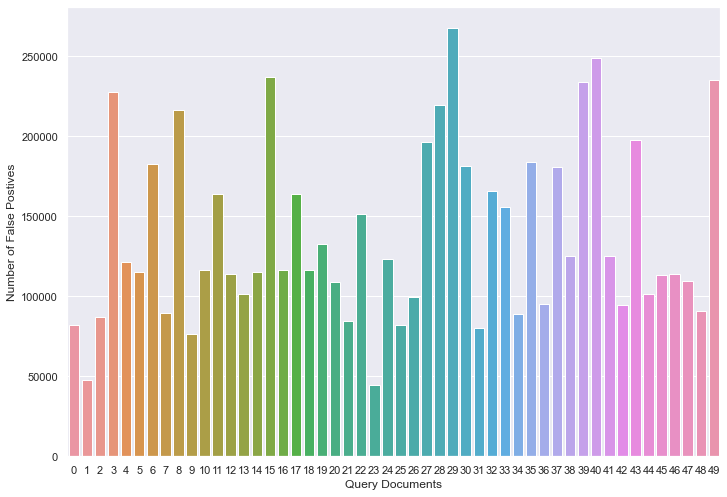

In [190]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
g=sns.barplot(x=list(fp.keys()),y=list(fp.values()))
g.set(ylabel='Number of False Postives', xlabel='Query Documents')

In [177]:
score=[]
for i in result:
   
    if i==0:
        df=pd.DataFrame(query.loc[i])
        score.append('Query')
    else:
        df=pd.concat([df,query.loc[i]],axis=1)
        score.append('Query')
    for j in result[i]:

        df=pd.concat([df,df_reduced.loc[j[1]]],axis=1)
        score.append(j[0])
df=df.T
df["Score"]=score
df.head(20)

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin,Score
0,94695.61,65.000000,38.0,245.000000,3.0,17.0,1.0,10.0,Query
1,7584.09,6025.000000,25.0,245.000000,1.0,7.0,7.0,10.0,Query
149232,5646.89,7000.000000,24.0,245.000000,1.0,7.0,7.0,10.0,[1.0]
2,7180.60,541.500000,25.0,222.000000,1.0,7.0,3.0,3.0,Query
102942,5993.34,606.900000,22.0,222.000000,1.0,7.0,3.0,3.0,[1.0]
79895,6763.42,525.000000,24.0,220.500000,1.0,7.0,3.0,3.0,[1.0]
61584,5615.66,618.000000,18.0,221.500000,1.0,7.0,3.0,3.0,[1.0]
3,56847.75,1000.000000,30.0,241.000000,2.0,13.0,5.0,9.0,Query
131727,55659.20,2010.614000,35.0,243.200000,2.0,13.0,5.0,9.0,[1.0]
33101,58026.99,2950.111111,29.0,241.555556,2.0,13.0,5.0,9.0,[1.0]


#### First from the barplot,we notice to have a high number of False positives.

#### In the above dataframe ,Query is identified by 'Query' in score column which is followed by top-3 most similar results.

> For some query we do not get any similar customers whose similarrity are greater than the threshold.

> For some query we get most similar customers in number less than 3.

In [56]:
result_1,fp_1=Query_LSH(query_sig_matrix,buckets,cust_matrix,0.6,40)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]
40it [00:00, ?it/s][A
  2%|█▋                                                                                 | 1/50 [00:02<01:58,  2.41s/it]
40it [00:00, ?it/s][A
  4%|███▎                                                                               | 2/50 [00:03<01:26,  1.80s/it]
40it [00:00, ?it/s][A
  6%|████▉                                                                              | 3/50 [00:06<01:41,  2.16s/it]
40it [00:00, ?it/s][A
  8%|██████▋                                                                            | 4/50 [00:13<03:03,  3.99s/it]
40it [00:00, ?it/s][A
 10%|████████▎                                                                          | 5/50 [00:16<02:54,  3.88s/it]
40it [00:00, ?it/s][A
 12%|█████████▉                                                                         | 6/50 [00:20<02:47,  3.80s/it]
40it [00:00, ?it/s][A
 14%|█

[Text(0, 0.5, 'Number of False Postives'), Text(0.5, 0, 'Query Documents')]

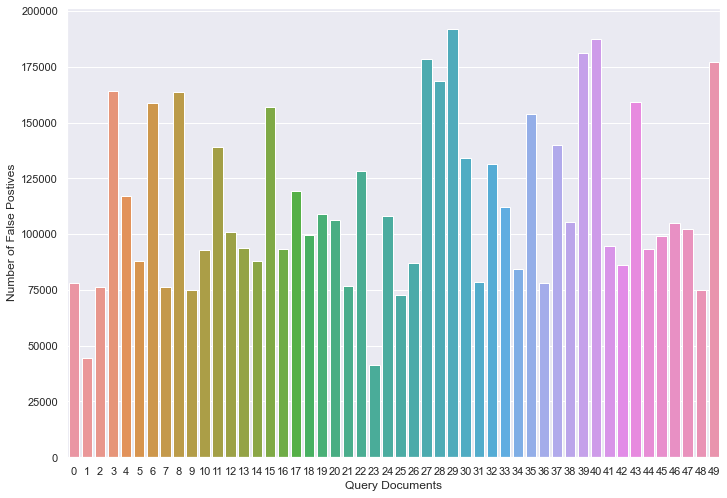

In [189]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g=sns.barplot(x=list(fp_1.keys()),y=list(fp_1.values()))
g.set(ylabel='Number of False Postives', xlabel='Query Documents')

In [176]:
score=[]
for i in result_1:
   
    if i==0:
        df=pd.DataFrame(query.loc[i])
        score.append('Query')
    else:
        df=pd.concat([df,query.loc[i]],axis=1)
        score.append('Query')
    for j in result_1[i]:

        df=pd.concat([df,df_reduced.loc[j[1]]],axis=1)
        score.append(j[0])
df=df.T
df["Score"]=score
df.head(20)

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin,Score
0,94695.61,65.000000,38.0,245.000000,3.0,17.0,1.0,10.0,Query
120322,82.19,163.666667,44.0,245.000000,3.0,1.0,1.0,10.0,[0.6]
28674,8852.34,194.000000,39.0,243.400000,3.0,8.0,1.0,10.0,[0.6]
17911,3798.36,240.521739,36.0,243.608696,3.0,6.0,1.0,10.0,[0.6]
1,7584.09,6025.000000,25.0,245.000000,1.0,7.0,7.0,10.0,Query
149232,5646.89,7000.000000,24.0,245.000000,1.0,7.0,7.0,10.0,[1.0]
149522,5468.46,346.000000,23.0,245.000000,1.0,7.0,2.0,10.0,[0.6]
143415,4.26,5696.740000,22.0,244.000000,1.0,1.0,7.0,10.0,[0.6]
2,7180.60,541.500000,25.0,222.000000,1.0,7.0,3.0,3.0,Query
102942,5993.34,606.900000,22.0,222.000000,1.0,7.0,3.0,3.0,[1.0]


#### First from the barplot,we notice to have a high number of False positives but these number are smaller than previous case.(that is what we expected with weaker constraint)

#### In the above dataframe ,Query is identified by 'Query' in score column which is followed by top-3 most similar results.

>In this case we notice for every query we got top-3 customers which have similarity greater than the threshold.

In [63]:
buckets_1=Candidate_Pairs(sig_matrix,20)
result_2,fp_2=Query_LSH(query_sig_matrix,buckets_1,cust_matrix,0.7,20)


20it [00:05,  3.60it/s]
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]
20it [00:00, 19831.22it/s]
  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.25it/s]
20it [00:00, ?it/s][A
  4%|███▎                                                                               | 2/50 [00:00<00:09,  5.28it/s]
20it [00:00, ?it/s][A
  6%|████▉                                                                              | 3/50 [00:00<00:09,  4.76it/s]
20it [00:00, ?it/s][A
  8%|██████▋                                                                            | 4/50 [00:01<00:27,  1.69it/s]
20it [00:00, ?it/s][A
 10%|████████▎                                                                          | 5/50 [00:01<00:19,  2.30it/s]
20it [00:00, ?it/s][A
 12%|█████████▉                                                                         | 6/50 [00:02<00:17,  2.56it/s]

[Text(0, 0.5, 'Number of False Postives'), Text(0.5, 0, 'Query Documents')]

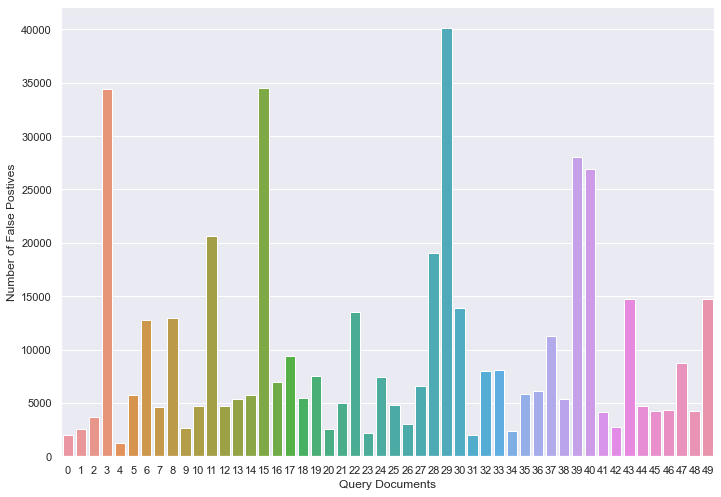

In [187]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
g=sns.barplot(x=list(fp_2.keys()),y=list(fp_2.values()))
g.set(ylabel='Number of False Postives', xlabel='Query Documents')

In [178]:
score=[]
for i in result_2:
   
    if i==0:
        df=pd.DataFrame(query.loc[i])
        score.append('Query')
    else:
        df=pd.concat([df,query.loc[i]],axis=1)
        score.append('Query')
    for j in result_2[i]:

        df=pd.concat([df,df_reduced.loc[j[1]]],axis=1)
        score.append(j[0])
df=df.T
df["Score"]=score
df.head(20)

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin,Score
0,94695.61,65.000000,38.0,245.000000,3.0,17.0,1.0,10.0,Query
1,7584.09,6025.000000,25.0,245.000000,1.0,7.0,7.0,10.0,Query
149232,5646.89,7000.000000,24.0,245.000000,1.0,7.0,7.0,10.0,[1.0]
2,7180.60,541.500000,25.0,222.000000,1.0,7.0,3.0,3.0,Query
80648,6956.46,602.000000,24.0,223.000000,1.0,7.0,3.0,3.0,[1.0]
65297,5942.23,684.500000,24.0,221.500000,1.0,7.0,3.0,3.0,[1.0]
61584,5615.66,618.000000,18.0,221.500000,1.0,7.0,3.0,3.0,[1.0]
3,56847.75,1000.000000,30.0,241.000000,2.0,13.0,5.0,9.0,Query
145427,51010.56,1200.000000,33.0,242.000000,2.0,13.0,5.0,9.0,[1.0]
145414,57166.86,1948.880000,28.0,243.000000,2.0,13.0,5.0,9.0,[1.0]


#### First from the barplot,we notice to have  appreciably reduce the number of False positives compared to the case where number of bands were 40.
#### In the above dataframe ,Query is identified by 'Query' in score column which is followed by top-3 most similar results.

>In this case we notice for every query we got top-3 customers which have similarity greater than the threshold.


In [195]:
result_3,fp_3=Query_LSH(query_sig_matrix,buckets_1,cust_matrix,0.6,20)

[Text(0, 0.5, 'Number of False Postives'), Text(0.5, 0, 'Query Documents')]

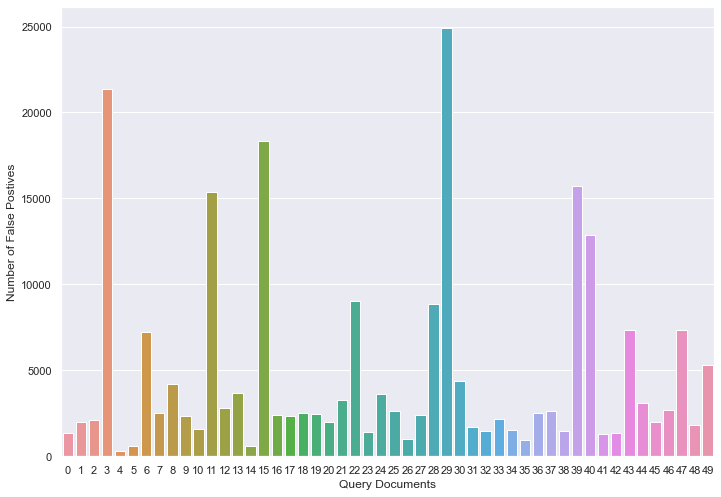

In [188]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
g=sns.barplot(x=list(fp_3.keys()),y=list(fp_3.values()))
g.set(ylabel='Number of False Postives', xlabel='Query Documents')

In [183]:
score=[]
for i in result_3:
   
    if i==0:
        df=pd.DataFrame(query.loc[i])
        score.append('Query')
    else:
        df=pd.concat([df,query.loc[i]],axis=1)
        score.append('Query')
    for j in result_3[i]:

        df=pd.concat([df,df_reduced.loc[j[1]]],axis=1)
        score.append(j[0])
df=df.T
df["Score"]=score
df.head(20)

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin,Score
0,94695.61,65.000000,38.0,245.000000,3.0,17.0,1.0,10.0,Query
147333,8218.37,100.000000,36.0,246.000000,3.0,8.0,1.0,10.0,[0.6]
146702,8392.99,106.000000,36.0,245.000000,3.0,8.0,1.0,10.0,[0.6]
28674,8852.34,194.000000,39.0,243.400000,3.0,8.0,1.0,10.0,[0.6]
1,7584.09,6025.000000,25.0,245.000000,1.0,7.0,7.0,10.0,Query
149232,5646.89,7000.000000,24.0,245.000000,1.0,7.0,7.0,10.0,[1.0]
35918,5629.43,6999.000000,23.0,215.000000,1.0,7.0,7.0,1.0,[0.6]
27137,7010.72,6839.000000,24.0,267.500000,1.0,7.0,7.0,17.0,[0.6]
2,7180.60,541.500000,25.0,222.000000,1.0,7.0,3.0,3.0,Query
80648,6956.46,602.000000,24.0,223.000000,1.0,7.0,3.0,3.0,[1.0]


#### First from the barplot,we notice to have  appreciably reduce the number of False positives compared to the case where number of bands were 40.
#### In the above dataframe ,Query is identified by 'Query' in score column which is followed by top-3 most similar results.

> For some query we do not get any similar customers whose similarity are greater than the threshold.

> For some query(just two) we get most similar customers in number less than 3.

### Final Comments and Observation:

> Computationally, we noticed that if we go for lower number of bands, it more time-efficient(as it has less hashing operations
to perform on the signature matrix).

> Using higher number of bands increase the number of False Positives which in turn increase the number of candidate pairs for calculations of Similarity.

> We notice that using two different bands combinations does not affect the performance of finding the similar customers. We get customers with same similarity score in both the case for individual query. 

> Since we have used four type of features to compute the similarity(quite sensitive),picking appropriate threshold is quite important to get results for each query. (which also depends on the objective of the task)
